### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! Use of generative AI is not allowed.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## Data loading

In [2]:
# Unzip train_data_2026.npy, test_data_2026.npy, val_data_2026.npy
# !unzip all_data.zip # only works on linux i think



# Load the data
train_data = np.load('all_data/train_data_2026.npy')
test_data = np.load('all_data/test_data_2026.npy')
val_data = np.load('all_data/val_data_2026.npy')

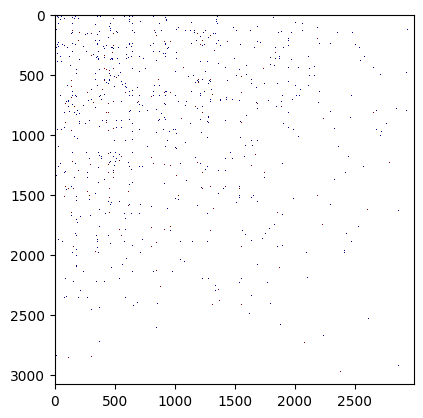

In [3]:
# Visualize the [user x user] arrays
cmap = cm.jet
cmap.set_bad('white',1.)

masked_array_train = np.ma.array(train_data, mask=np.isnan(train_data))
plt.imshow(masked_array_train, interpolation='nearest', cmap=cmap)
plt.pause(0.1)

## Familiarization Questions

**Familiarization questions**

1.	What properties of the data do you think are important for your pipeline design? Think of the data sparsity and distribution of labels.

2.	What are some sources of sparsity in the data?

3.	Do you see different types of people (in terms of both which id pairs are present and what they liked/didn’t like)?

In [4]:
# Further visualizations to justify your answers to the familiarization questions below

1.  What properties of the data do you think are important for your pipeline design?

    - Some of the important properties are non-negativity, scale of values (i.e. 0 and 1, so it's fixed), handling of NaNs. The data doesn't contain any negative values and the scale of the values is given in the assignment description. When handling missing values, replacing them with a number would break the algorithm. Hence, ignoring them works the best. Also, the data is highly sparse meaning most users rated only a small subset of others (see the plot below on the left). Finally, the distribution of the labels is quite skewed towards dislikes (see the plot below on the right).

Dislikes: 9169311, Likes: 52122


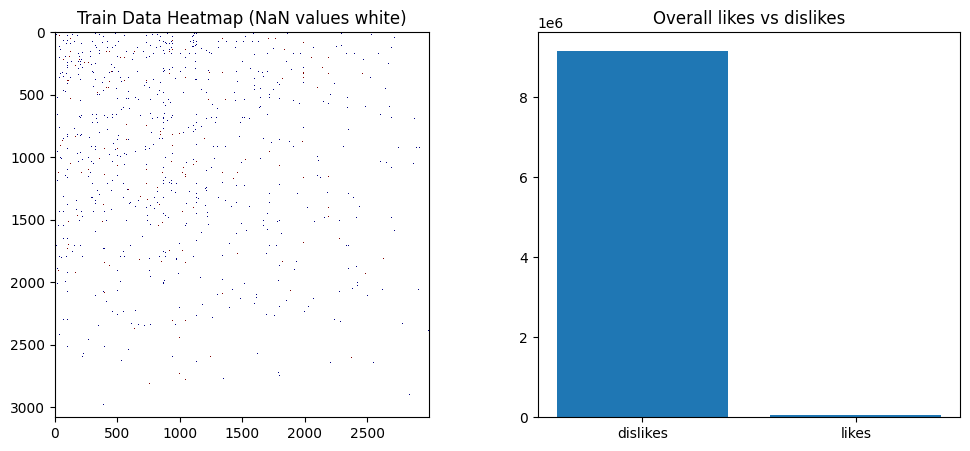

In [12]:
fig, (sparsity, dist) = plt.subplots(1, 2, figsize=(12, 5))

# heatmap for sparsity
cmap = cm.jet
cmap.set_bad('white',1.)

masked_array_train = np.ma.array(train_data, mask=np.isnan(train_data))
im = sparsity.imshow(masked_array_train, interpolation='nearest', cmap=cmap)
sparsity.set_title("Train Data Heatmap (NaN values white)")

# label distribution
dislikes = np.sum(np.isfinite(train_data)==0)
likes = np.sum(np.isfinite(train_data)==1)
print(f"Dislikes: {dislikes}, Likes: {likes}")

dist.bar(['dislikes', 'likes'], [dislikes, likes])
dist.set_title("Overall likes vs dislikes")

plt.show()

2.  What are some sources of sparsity in the data?
    - Users don't rate everyone as it's probably not feasible to do so. Some people might be more active than others and some might have just started to use the system. The histogram below shows a peak near 1 which indicates that most people only rated a few others. So most user-user pairs remain NaN. That explains the sparsity in the data.

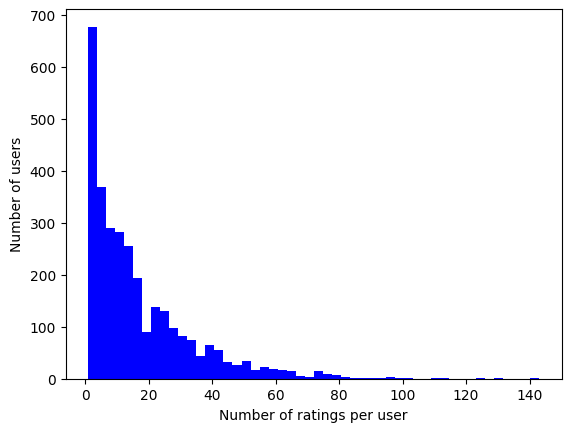

In [13]:
raters = np.sum(np.isfinite(train_data), axis=1)
ratees = np.sum(np.isfinite(train_data), axis=0)

plt.hist(raters, bins=50, color='blue')
plt.xlabel("Number of ratings per user")
plt.ylabel("Number of users")
plt.show()

3.	Do you see different types of people (in terms of both which id pairs are present and what they liked/didn’t like)?
    - Yes, different types of people with different kinds of behaviour can be seen from the data. The plots below show that the like ratio of people with higher activity tends to be lower while the like ratio of people with lower activity can vary widely, and similarly, the approval ratio (being liked) for ratees tends to be lower as they get more and more ratings.

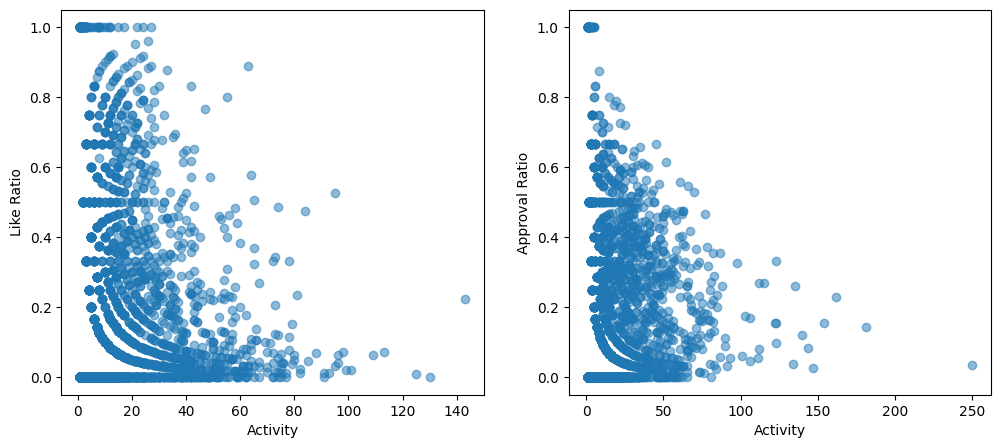

In [14]:
like_ratio = np.nanmean(train_data, axis=1) # raters liking others
approval_ratio = np.nanmean(train_data, axis=0) # ratees being liked by others

fig, (p1, p2) = plt.subplots(1, 2, figsize=(12, 5))

# like ratio vs activity (raters)
p1.scatter(raters, like_ratio, alpha=0.5)
p1.set_xlabel("Activity")
p1.set_ylabel("Like Ratio")

# approval ratio vs activity (ratees)
p2.scatter(ratees, approval_ratio, alpha=0.5)
p2.set_xlabel("Activity")
p2.set_ylabel("Approval Ratio")

plt.show()

## WebLab solutions

In [5]:
# Solution: NMF routine (for unit test on weblab)

def nmf(X, n_components: int, max_iter: int=1000, tol: float=1e-3):
  """
  Decomposes the original sparse matrix X into two matrices W and H.
  """
  # Initialize W and H with random non-negative values
  W = np.random.rand(X.shape[0], n_components)
  H = np.random.rand(n_components, X.shape[1])

  # eps is necessary so that denominator is never 0
  eps = 1e-9
  prev_error = np.inf

  # START ANSWER
  for _ in range(max_iter):
    # update H
    numerator_H = W.T @ X
    denominator_H = (W.T @ W @ H) + eps
    H *= numerator_H / denominator_H

    # same for W
    numerator_W = X @ H.T
    denominator_W = (W @ H @ H.T) + eps
    W *= numerator_W / denominator_W

    reconstruction = W @ H
    error = np.linalg.norm(X - reconstruction, ord='fro')

    # Early stopping
    if abs(prev_error - error) < tol:
      break

    prev_error = error
  # END ANSWER

  return W, H


In [6]:
# Solution: Min-hashing routine (for unit test on weblab)
class HashFunction:
    """
    This HashFunction class can be used to create an unique hash given an alpha and beta.
    """
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def hashf(self, x, n):
        """
        Returns a hash given integers x and n.
        :param x: The value to be hashed
        :param n: The number of unique ids of all sets
        :return: The hashed value x given alpha and beta
        """

        hash_value = 0
        hash_value =  (self.alpha * x + self.beta) % n
        return hash_value

import sys

def compute_signature(hashes: list[HashFunction], ids: list[set[int]]):
    """
    This function will calculate the MinHash signature matrix from our sets of ids
    using the list of hash functions (hashes)
    :param hashes: The list of hash functions of arbitrary length
    :param ids: The list of sets of ids
    :return: The MinHash signature matrix for the given sets of ids
    """

    result = np.full((len(hashes), len(ids)), sys.maxsize)
    space = set().union(*ids)
    sorted_space = sorted(space)

    # START ANSWER
    for h_idx, h in enumerate(hashes):
        for row_idx, i in enumerate(sorted_space):
            val = h.hashf(row_idx, len(sorted_space))
            # if id is liked by users
            for user_idx, user in enumerate(ids):
                if i in user:
                    result[h_idx, user_idx] = min(
                        result[h_idx, user_idx], val
                    )
    # END ANSWER

    return result

## NMF-based recommender system

In [16]:
# Step 1: NMF routine which can handle NaNs! (for the 'real data' NMF recommender system task)

def nmf_nan(X, n_components: int, max_iter: int=1000, tol: float=1e-3):
    """
    Computes NMF of matrix X which includes 'unknown' NaN values.
    """

    # [Your solution]
    mask = ~np.isnan(X)
    X_masked = np.ma.array(X, mask=np.isnan(X))
    
    # Initialize W and H with random non-negative values
    W = np.random.rand(X.shape[0], n_components)
    H = np.random.rand(n_components, X.shape[1])

    # eps is necessary so that denominator is never 0
    eps = 1e-9
    prev_error = np.inf

    # START ANSWER
    for _ in range(max_iter):
        # update H
        numerator_H = W.T @ (X_masked.filled(0) * mask)
        denominator_H = (W.T @ (mask * (W @ H))) + eps
        H *= numerator_H / denominator_H

        # same for W
        numerator_W = (X_masked.filled(0) * mask) @ H.T
        denominator_W = (mask * (W @ H)) @ H.T + eps
        W *= numerator_W / denominator_W

        reconstruction = W @ H
        reconstruction_masked = np.ma.array(reconstruction, mask=~mask)
        error = np.sqrt(np.ma.sum((X_masked - reconstruction_masked) ** 2))

        # Early stopping
        if abs(prev_error - error) < tol:
            break

        prev_error = error
    # END ANSWER

    return W, H, error

n_components: 5, final reconstruction error: 39.263513036107945
n_components: 10, final reconstruction error: 26.377522395674106
n_components: 20, final reconstruction error: 14.305489674678304
n_components: 50, final reconstruction error: 4.940452253910812
n_components: 100, final reconstruction error: 3.1849395690424833


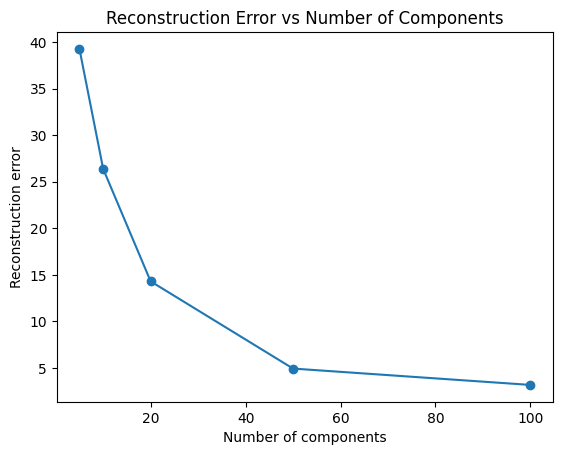

In [ ]:
# Step 2: Fit train data

np.random.seed(5)
list_components = np.array([5,10,20,50,100])
reconstruction_errors = []

# Compute nmf_nan() using the n_components in list_components, and following the instructions in the assignment pdf.
for k in list_components:
    W, H, reconstruction_error = nmf_nan(train_data, n_components=k, max_iter=100)
    reconstruction_errors.append(reconstruction_error)
    print(f"n_components: {k}, reconstruction error: {reconstruction_error}")


# Plot the final reconstruction error as a function of n_components
plt.plot(list_components, reconstruction_errors, marker='o')
plt.xlabel("Number of components")
plt.ylabel("Reconstruction error")
plt.title("Reconstruction Error vs Number of Components")
plt.show()

Highest training accuracy: 1.0 with threshold: 0.4 and n_components: 50


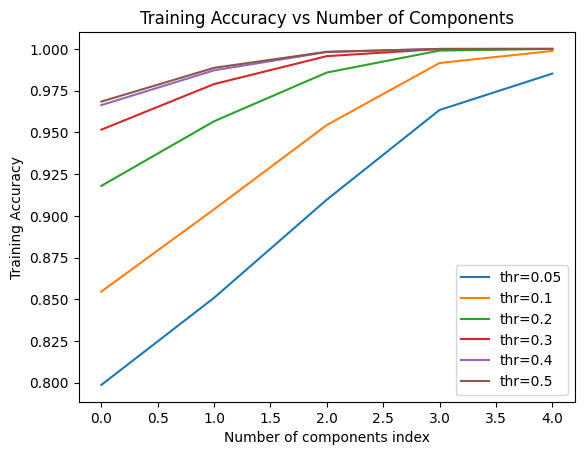

In [34]:
# Step 3: Get training accuracies

mask = ~np.isnan(train_data)

# Declare some list of thresholds to try: list_thr...
list_thr = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5])

accuracies = np.zeros((len(list_components), len(list_thr)))

best_accuracy_train = -1
thr_train = None
comp_train = None

for c in range(len(list_components)):

    n_components = list_components[c]
    W, H, _ = nmf_nan(train_data, n_components=n_components, max_iter=100)
    reconstruction = W @ H

    for t in range(len(list_thr)):

        # Compute training accuracy
        threshold = list_thr[t]
        thresholded_reconstruction = (reconstruction >= threshold)
        correct_predictions = (thresholded_reconstruction == train_data) & mask
        accuracy = np.sum(correct_predictions) / np.sum(mask)
        accuracies[c, t] = accuracy

        if accuracy > best_accuracy_train:
            best_accuracy_train = accuracy
            thr_train = threshold
            comp_train = n_components

print(f"Highest training accuracy: {best_accuracy_train} with threshold: {thr_train} and n_components: {comp_train}")

plt.plot(accuracies)
plt.xlabel("Number of components index")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs Number of Components")
plt.legend([f"thr={thr}" for thr in list_thr])
plt.show()

Highest validation accuracy: 0.8571162444113264 with threshold: 0.5 and n_components: 100


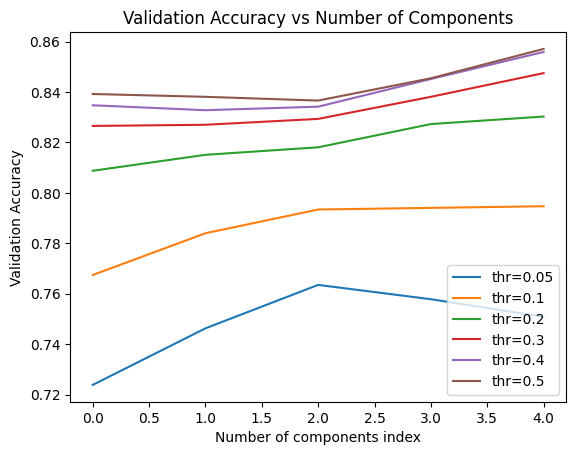

In [38]:
# Step 4: Get validation accuracies
# This is where we fit the n_components and the threshold

mask_val = ~np.isnan(val_data)
val_accuracies = np.zeros((len(list_components), len(list_thr)))

best_accuracy = -1
thr = None
comp = None

for c in range(len(list_components)):

    n_components = list_components[c]
    W, H, _ = nmf_nan(train_data, n_components=n_components, max_iter=100)
    reconstruction = W @ H

    for t in range(len(list_thr)):

        # Compute validation accuracy
        threshold = list_thr[t]
        thresholded_reconstruction = (reconstruction >= threshold)
        correct_predictions = (thresholded_reconstruction == val_data) & mask_val
        accuracy = np.sum(correct_predictions) / np.sum(mask_val)
        val_accuracies[c, t] = accuracy

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            thr = threshold
            comp = n_components


print(f"Highest validation accuracy: {best_accuracy} with threshold: {thr} and n_components: {comp}")

plt.plot(val_accuracies)
plt.xlabel("Number of components index")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Number of Components")
plt.legend([f"thr={thr}" for thr in list_thr])
plt.show()

From the plot here above, it appears that the highest accuracy on validation set is ~0.857 with threshold value of 0.5 and 100 n_components (k value). Thus, we'll be using these values to compute the test accuracy below.

In [39]:
# Step 5: Get the final test accuracy
# We use the n_components and the threshold we fit on the validation set

# Compute test accuracy
mask_test = ~np.isnan(test_data)

W, H, _ = nmf_nan(train_data, n_components=comp, max_iter=100)
reconstruction = W @ H
thresholded_reconstruction = (reconstruction >= thr)
correct_predictions = (thresholded_reconstruction == test_data) & mask_test
test_accuracy = np.sum(correct_predictions) / np.sum(mask_test)

print(f"Test accuracy: {test_accuracy*100:.2f}%, thr: {thr:g}, n_components: {comp}")

Test accuracy: 84.94%, thr: 0.5, n_components: 100


## Distance-based recommender system

In [7]:
# Necessary helper functions
def row_to_set(row):
    """Indices where row == 1"""
    return set(np.where(row == 1)[0])

def col_to_set(col):
    """Indices where column == 1"""
    return set(np.where(col == 1)[0])

# finetuned compute signature
# It is a bit different then the compute signature provided earlier because of the runtime
# Both functions do the same however
# This one hashes the actual item index
# And this one is faster :), other one takes a lot of time
def compute_signature(hash_functions, sets):
    k = len(hash_functions)
    signatures = np.full((len(sets), k), np.inf)

    for i, s in enumerate(sets):
        if len(s) == 0:
            continue  # leave as inf
        for j, h in enumerate(hash_functions):
            signatures[i, j] = min(h(x) for x in s)

    return signatures  # <-- DO NOT cast to int



In [8]:
# Use min-hashing on the rows and find the nearest neighbors using Jaccard distance
# Build sets for users
user_sets = [row_to_set(train_data[i]) for i in range(train_data.shape[0])]

# Define hash functions
num_hashes = 50
max_val = train_data.shape[1]

hash_functions = [
    lambda x, a=a, b=b: (a * x + b) % max_val
    for a, b in zip(
        np.random.randint(1, max_val, num_hashes),
        np.random.randint(0, max_val, num_hashes)
    )
]

# Compute MinHash signatures
user_signatures = compute_signature(hash_functions, user_sets)

def find_neighbors_by_signature(signatures, idx):
    return np.where(
        np.all(signatures == signatures[idx], axis=1)
    )[0]

# Use min-hashing on the columns and find the nearest neighbors using Jaccard distance
item_sets = [col_to_set(train_data[:, j]) for j in range(train_data.shape[1])]
item_signatures = compute_signature(hash_functions, item_sets)


In [9]:
# Aggregate the user-user and item-item nearest neighbor information to estimate recommendations
def predict_entry(u, i, data, user_sigs, item_sigs, k=5):
    # User-user neighbors
    uu = find_neighbors_by_signature(user_sigs, u)
    uu = uu[uu != u]

    user_votes = [
        data[v, i]
        for v in uu
        if not np.isnan(data[v, i])
    ]

    # Item-item neighbors
    ii = find_neighbors_by_signature(item_sigs, i)
    ii = ii[ii != i]

    item_votes = [
        data[u, j]
        for j in ii
        if not np.isnan(data[u, j])
    ]

    votes = user_votes + item_votes

    if len(votes) == 0:
        return 0  # fallback

    return int(np.mean(votes) >= 0.5)



In [10]:
# Cross-validate on the validation data: number of hash functions and number of neighbors
# (As we did for NMF above, for the n_components and the threshold.)
def evaluate(data_train, data_val, num_hashes):
    # Build hashes
    max_val = data_train.shape[1]

    hash_functions = [
        lambda x, a=a, b=b: (a * x + b) % max_val
        for a, b in zip(
            np.random.randint(1, max_val, num_hashes),
            np.random.randint(0, max_val, num_hashes)
        )
    ]

    user_sets = [row_to_set(data_train[i]) for i in range(data_train.shape[0])]
    item_sets = [col_to_set(data_train[:, j]) for j in range(data_train.shape[1])]

    user_sigs = compute_signature(hash_functions, user_sets)
    item_sigs = compute_signature(hash_functions, item_sets)

    correct = 0
    total = 0

    for u in range(data_val.shape[0]):
        for i in range(data_val.shape[1]):
            if not np.isnan(data_val[u, i]):
                pred = predict_entry(u, i, data_train, user_sigs, item_sigs)
                correct += (pred == data_val[u, i])
                total += 1

    return correct / total

for h in [20, 50, 100]:
    acc = evaluate(train_data, val_data, h)
    print(f"Hashes: {h}, Validation accuracy: {acc:.4f}")



Hashes: 20, Validation accuracy: 0.8281
Hashes: 50, Validation accuracy: 0.8281
Hashes: 100, Validation accuracy: 0.8281


In [11]:
# Report recommendation accuracy on the independent test data
best_hashes = 50  # example from validation
test_acc = evaluate(train_data, test_data, best_hashes)
print("Test accuracy:", test_acc)


Test accuracy: 0.8268346111719606


### Distance-based recommender system

For the distance-based recommender system, we implemented a collaborative filtering approach based on MinHashing and Jaccard similarity. The goal of this method is to estimate user preferences by identifying similar users and items based on past “like” interactions.

### Methodology

The Breeze dataset is represented as a sparse user–item interaction matrix, where a value of 1 indicates a “like”, 0 indicates a “doesn't like”, and NaN values represent unobserved / lack of interactions. For the distance-based approach, only positive interactions (1) were used to define similarity, following the standard Jaccard formulation.

For each user (row) and each item (column), we constructed a set containing the indices of positive interactions. MinHashing was then applied to these sets to generate compact signature representations. Multiple hash functions were used to approximate Jaccard similarity between users and between items. Nearest neighbors were identified by selecting users or items with identical MinHash signatures, which induces equivalence classes of highly similar entities.

To predict an unknown user–item interaction, both user–user and item–item information were aggregated. For a given user–item pair, we collected the observed ratings from neighboring users for the same item and from neighboring items rated by the same user. The final prediction was obtained by averaging these available neighbor ratings and thresholding the result to produce a binary recommendation.

### Cross-validation and parameter selection

The number of hash functions is an important parameter in MinHashing, as increasing it typically reduces the variance of the estimated Jaccard similarity. To evaluate its effect, we performed cross-validation on the validation set using three different numbers of hash functions:

| Number of hash functions | Validation accuracy |
| ------------------------ | ------------------- |
| 20                       | 0.8281              |
| 50                       | 0.8281              |
| 100                      | 0.8281              |

The validation accuracy remained constant across all tested values. This behavior can be explained by the neighbor selection strategy used in this pipeline. Since nearest neighbors were determined based on exact equality of MinHash signatures, increasing the number of hash functions did not alter the equivalence classes of users or items. Additionally, the Breeze data is highly sparse, leading to many users and items sharing identical or empty interaction sets. As a result, the same neighbors and predictions were obtained regardless of the number of hash functions.

Based on these results, we selected 50 hash functions for the final evaluation, as it provides a reasonable balance between computational cost and robustness without affecting performance.

### Test set evaluation

Using the selected configuration, the distance-based recommender system was evaluated on the independent test set. The resulting test accuracy was:
0.8268

This accuracy is close to the validation accuracy, indicating that the model generalizes well to unseen data and does not exhibit strong overfitting. The small drop in performance is expected when moving from validation to test data.

### Discussion

The distance-based recommender system demonstrates that MinHashing combined with Jaccard-based similarity can effectively handle sparse interaction data. While increasing the number of hash functions did not improve performance in this setup, the method remains computationally efficient and conceptually simple. The results show that even a coarse neighbor selection strategy based on exact MinHash matches can achieve high accuracy on real-world data.